# Introduction

### Overview
I participated in the IMA-MathCEP Math Modeling Camp at the University of Minnesota in July 2024, engaging in a team-based project focused on mathematical modeling. The project addressed California’s 2035 mandate requiring all new vehicle purchases to be battery, plug-in hybrid, or fuel-cell electric vehicles, which increases electricity demand. My team analyzed how to meet this demand using renewable energy while keeping electricity costs low. The objectives included modeling greenhouse gas (GHG) emissions from vehicles, predicting energy grid changes, and optimizing the grid to meet California’s renewable energy targets.


## Background
California regulators recently adopted rules that would require all new purchases of cars and light trucks (starting in 2035) to include only battery, plug-in, or fuel-cell electric vehicles. This will reduce tailpipe emissions from vehicles, but will greatly increase the demand on the electric grid.

## Problem
You have been hired as a consultant by the state of California to suggest how they might meet this new electric demand in an environmentally responsible way. However, since the new vehicles will be more expensive, there is political pressure to ensure that the cost per kilowatt-hour (cost/kW) of electricity is low. Create a model that shows how quickly green house gas emission will decrease, and justify your choice of new energy production.

## Objectives
1. Develop a model to predict the reduction in greenhouse gas (GHG) emissions from vehicles as California transitions to electric vehicles by 2035.
2. Forecast the evolution of California’s energy grid to meet increasing electricity demand, aligning with the state’s renewable energy goals (52% by 2022, 60% by 2030, 90% by 2040, and 100% by 2045).
3. Optimize the energy grid to minimize the cost per kilowatt-hour while maximizing renewable energy sources, using a genetic algorithm to balance cost and environmental impact.

# Objective 1: Carbon Dioxide Emissions from Vehicles

## Objective Statement
Create a model to accurately predict the greenhouse gas (GHG) emissions from vehicles as the regulations take effect. This will be done in 2 steps: Create a function for GHG emissions from vehicles and derive the necessary parameter for the function

## Assumptions
- Carbon dioxide is the only GHG considered
- All cars that are registered are active
- The number of cars manufactured is equivalent to the number of cars sold

## Modeling
We will divide the function into two pieces: Before 2035 and after 2035. Before 2035, teh function considers carbon dioxide emitted from manufacturing cars and operating gasoline cars. After 2035, the function only considers carbon dioxide emitted from manufacturing cars. With mathematical intuition and public data available throught the State of California, my team was able to deduce the following function below.

$$\begin{equation*}
\mathrm{CO}_2
\mathrm{ \ emissions \ from \ vehicles}=
\begin{cases}
    \mathrm{CO}_2 \ \mathrm{from \ gas \ car \ tailpipes} + \mathrm{CO}_2 \ \mathrm{from \ gas \ car \ manufacture} + \mathrm{CO}_2 \ \mathrm{from \ EV \ manufacture} & \mathrm{} \ 2021 \leq t \leq 2035 \\
    \mathrm{CO}_2 \ \mathrm{from \ gas \ car \ manufacture} + \mathrm{CO}_2 \ \mathrm{from \ EV \ manufacture} & \mathrm{} \ 2035 < t \leq 2050
\end{cases}
\end{equation*}$$

### $\mathrm{CO}_2\$ from car tailpipes
$$=\mathrm{CO}_2 \ \mathrm{gas \ car \ emimssions \ per \ year} \cdot \mathrm{Gas \ car \ registration \ percentage} \cdot \mathrm{Annual \ number \ of \ car \ registrations}$$

$$
= \frac{
4.6 \times
\left\{
\begin{array}{ll}
\displaystyle \frac{9600e^{-0.123(t - 2016)}}{4 + 96e^{-0.123(t - 2016)}} & \text{for } 2021 \leq t < 2035 \\[10pt]
224.3e^{-0.0833(t - 2021)} & \text{for } t \geq 2035
\end{array}
\right.
\times \left[0.846(t - 2021) + 35 \cdot 10^6 \right]
}{100}
$$

### $\mathrm{CO}_2 \$ from gas car manufacture
$$=\mathrm{number \ of \ total \ cars \ sold} \cdot\mathrm{\% \ of \ gas \ car \ sold}\cdot\mathrm{6 \ metric \ tons}$$

$$=[0.041(t-2021) + 1,860,000]\times\frac{99.7 - 7.3(t-2021)}{100}\times6$$

### $\mathrm{CO}_2\$ from EV manufacture
$$=\mathrm{number \ of \ total \ cars \ sold}\cdot\mathrm{\% \ of \ electric \ cars \ sold}\cdot10\mathrm{\ metric \ tons}$$

$$=[0.041(t-2021) + 1,860,000]\times\frac{0.3 + 7.3(t-2021)}{100}\times10$$

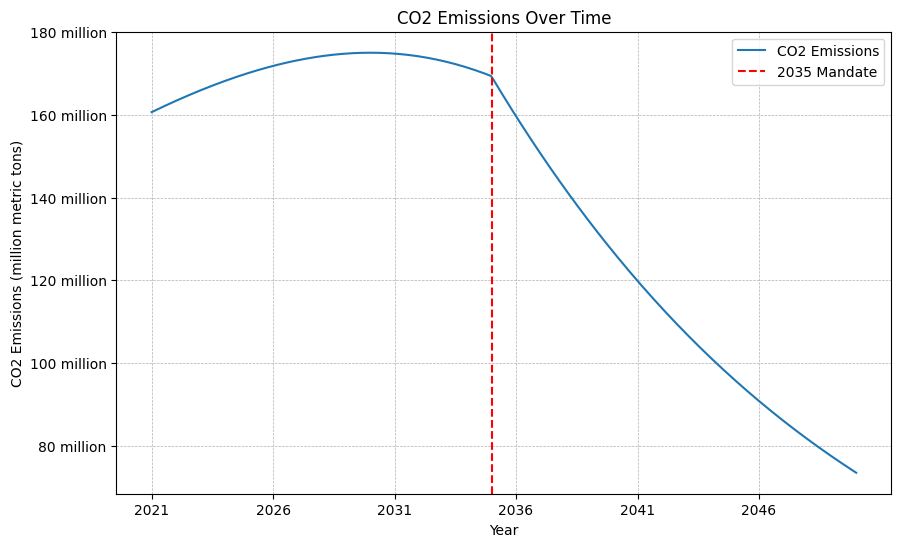

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define the piecewise function for CO2 emissions
def co2_emissions(t):
    if t < 14:
        term1 = ((35 * 10**6 + 846000 * t) * (4.6 * 9600 * np.exp(-0.123 * (t + 5)) / (4 + 96 * np.exp(-0.123 * (t + 5))))) / 100
        term2 = ((0.04 * t + 1.86 * 10**6) * (99.7 - 7.3 * t) * 6) / 100
        term3 = ((0.04 * t + 1.86 * 10**6) * (7.3 * t + 0.3) * 10) / 100
        return term1 + term2 + term3
    else:
        term1 = ((35 * 10**6 + 846000 * t) * (224.33 * np.exp(-0.0833 * t)) * 4.6) / 100
        term2 = (0.04 * t + 1.86 * 10**6) * 10
        return term1 + term2

# Create a range of t values starting from 2021
years_start = 2021
t_values = np.linspace(0, 29, 300)  # 29 years from 2021 to 2049

# Compute the CO2 emissions for each t value
emissions = np.array([co2_emissions(t) for t in t_values])

# Plot the function
plt.figure(figsize=(10, 6))
plt.plot(t_values + years_start, emissions, label='CO2 Emissions')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.title('CO2 Emissions Over Time')
plt.xticks(np.arange(years_start, years_start + 30, step=5))  # Adjust x-axis ticks every 5 years
plt.legend()
plt.grid(True)

# Format y-axis labels in a million metric tons without trailing zeros
formatter = ticker.FuncFormatter(lambda x, pos: '{:.0f} million'.format(x / 1e6))
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

# Objective 2: Energy Grid Prediction

## Objective Statement
Predict how the percentages of various energy sources responsible for energy production in the elctric grid change over time.

## California's Goal's for the Energy Grid
- 2022: 52% Renewable Energy
- 2030: 60% Renewable Energy
- 2040: 90% Renewable Energy
- 2045: 100% Renewable Energy

## California's Definition of "Renewable Energy"
California defines renewable energy sources as anything that has zero direct GHG emissions. For exmaple, nuclear power is considered renewable since there are no direct GHG emissions.

## Assumptions
- Only seven energy sources (coal, geothermal, natural gas, nuclear, solar, wind, and others combined) will be considered

# Regression Models for Energy Sources
This section analyzes the historical trends (2009 - 2022) in energy source usage to derive the regression models that depict the evolution of each source over time. The data used was released by the [California government](https://www.energy.ca.gov/media/7311). _NormalizedEnergyData_ shows the cleaned up data of the given information. Since Biomass, Large Hydro, and Small Hydro has composed such a small amount of energy production in California for the past 13 years, we combine these sources as 'Others'.

Plotting and finding regression models of the energy sources through Apple Numbers yield the following results:

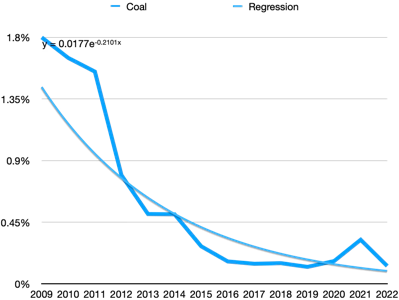
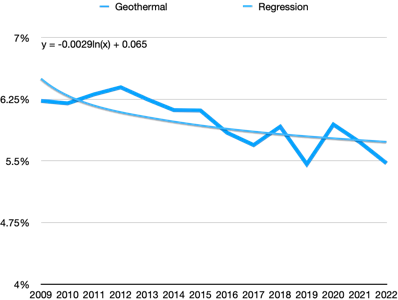
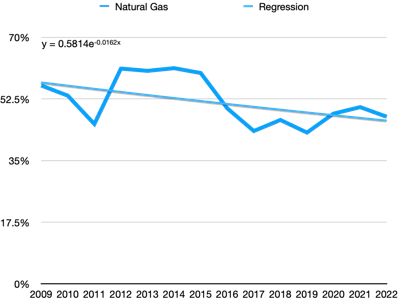
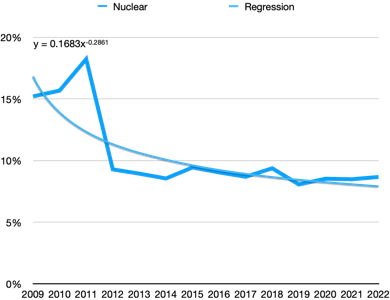
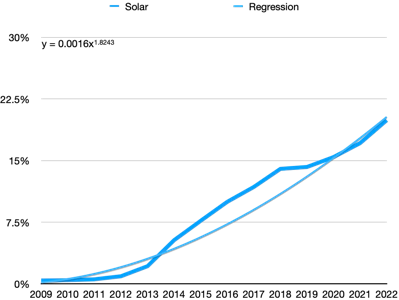
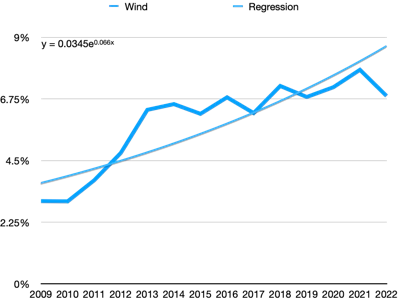
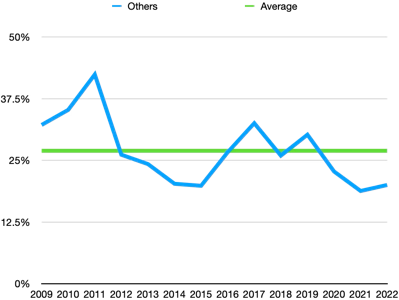

Let $x_i(t)$ denote the percentage of energy source $i$ at year $t$. Given the regression analysis of past data, we can derive the following:
- $x_{coal}(t)=0.0177e^{-0.2101(t-2009)}$
- $x_{geothermal}(t)=-0.0029\ln(t-2009)+0.065$
- $x_{natural \ gas}(t)=0.5814e^{-0.0162(t-2009)}$
- $x_{nuclear}(t)=0.1683(t-2009)^{-0.2861}$
- $x_{solar}(t)=0.0016(t-2009)^{1.8243}$
- $x_{wind}(t)=0.0345e^{0.066(t-2009)}$
- $x_{others}(t)=\mathrm{rand(21, 31)}$
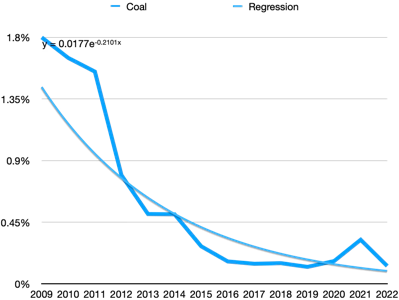
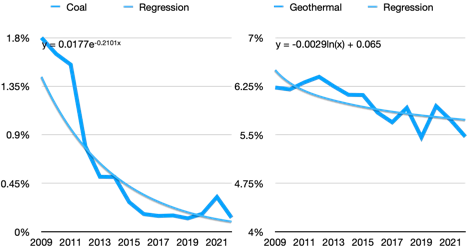
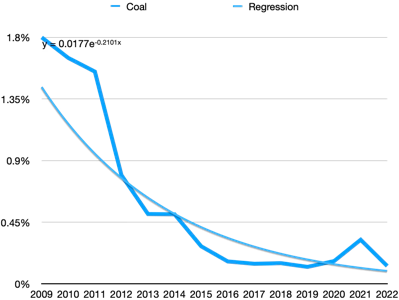